# Codes de l'analyse des stations du Rayol

# Packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import sys
import numpy as np
import matplotlib
import seaborn as sb
import scipy
import seaborn as sns
import xgboost
import shap
import math
from ipykernel import kernelapp as app
from matplotlib import pyplot as mp
from scipy import stats
from pylab import rcParams
from pandas.plotting import scatter_matrix
from scipy.stats.stats import pearsonr
sns.set(style="ticks")

# Definition des fonctions

In [2]:
#Extraction of the date, hour, day and month from the file name
def trans1(G):
    X=G.copy()
    X['DATE']=pd.to_datetime('01-01-01 00:00:00')
    X['DAY']=0
    X['MONTH']=0
    X['HOUR']=0
    X['MINUTES']=0
    X['SECONDS']=0

    for i in X.index:
        tp=X.loc[i,('FILENAME')].split('_')
        tpd=tp[1]
        tph=tp[2].split('.')[0].replace('-',':')
        tp2=pd.to_datetime(tpd+' '+tph)
        X.loc[i,('DATE')]=tp2
        X.loc[i,('MONTH')]=int(tpd[5:7])
        X.loc[i,('DAY')]=int(tpd[8:10])
        X.loc[i,('HOUR')]=int(tph[:2])
        X.loc[i,('MINUTES')]=int(tph[3:5])
        X.loc[i,('SECONDS')]=int(tph[6:8])
    return X;

def trans2(XX):

    arrays = [['ndsi','ndsi','ndsi','ndsi','ndsi','ndsi','ndsi','ndsi','ndsi',
              'AC','AC','AC','AC','AC','AC','AC','AC','AC',
              'AD','AD','AD','AD','AD','AD','AD','AD','AD',
              'BI','BI','BI','BI','BI','BI','BI','BI','BI',
              'H','H','H','H','H','H','H','H','H'
              ],
             ['MEAN','STD','VAR','MEDIAN','MODE','MIN','MIN_DATE','MAX','MAX_DATE',
              'MEAN','STD','VAR','MEDIAN','MODE','MIN','MIN_DATE','MAX','MAX_DATE',
              'MEAN','STD','VAR','MEDIAN','MODE','MIN','MIN_DATE','MAX','MAX_DATE',
              'MEAN','STD','VAR','MEDIAN','MODE','MIN','MIN_DATE','MAX','MAX_DATE',
              'MEAN','STD','VAR','MEDIAN','MODE','MIN','MIN_DATE','MAX','MAX_DATE']
             ]
    tuples = list(zip(*arrays))
    columns = pd.MultiIndex.from_tuples(tuples)
    Y=pd.DataFrame(columns=columns,
                   index=np.arange(0,48,1)
                  )
    indlist=['ndsi','AC','AD','BI','H']
    for i in indlist:
        
        for n in np.arange(0,48,2):
            j=n
            for k in [0,30]:
                tp=XX.loc[(XX['HOUR']==n/2)&(XX['MINUTES']>=k)&(XX['MINUTES']<k+30)]
                tp=tp.reset_index(drop = True)
                Y.loc[j,(i,'MEAN')]=np.mean(tp[i])
                Y.loc[j,(i,'STD')]=np.std(tp[i])
                Y.loc[j,(i,'VAR')]=np.var(tp[i])
                Y.loc[j,(i,'MEDIAN')]=np.median(tp[i])
                Y.loc[j,(i,'MODE')]=stats.mode(tp[i])[0][0]
                Y.loc[j,(i,'MIN')]=np.min(tp[i])
                Y.loc[j,(i,'MIN_DATE')]=tp.loc[(tp[i]==np.min(tp[i]))]['DATE'].values[0]
                Y.loc[j,(i,'MAX')]=np.max(tp[i])
                Y.loc[j,(i,'MAX_DATE')]=tp.loc[(tp[i]==np.max(tp[i]))]['DATE'].values[0]
                j+=1
    return Y;

#Fusion of the toxw others functions
def trans12(S):
    s1=trans1(S)
    s2=trans2(s1)
    return [s1,s2]

# Chargement des données

In [3]:
liste = pd.read_csv('data_in/listecsv.csv',header = None)
entrees=pd.read_csv('data_in/Compteur.csv')
freq=pd.read_csv('data_in/frequentation.csv')

WD={'lundi':1,'mardi':2,'mercredi':3,'jeudi':4,'vendredi':5,'samedi':6,'dimanche':7}
Mth={'janvier':1,'fevrier':2,'mars':3,'avril':4,'mai':5,'juin':6,'juillet':7,'aout':8,'septembre':9,'octoblre':10,'novembre':11,'decembre':12}
H24=np.arange(0,24,1)
FreqVisites={
    'lundi':freq.loc[freq['W_day']=='lundi'].loc[:,('Freq_0')].values,
    'mardi':freq.loc[freq['W_day']=='mardi'].loc[:,('Freq_0')].values,
    'mercredi':freq.loc[freq['W_day']=='mercredi'].loc[:,('Freq_0')].values,
    'jeudi':freq.loc[freq['W_day']=='jeudi'].loc[:,('Freq_0')].values,
    'vendredi':freq.loc[freq['W_day']=='vendredi'].loc[:,('Freq_0')].values,
    'samedi':freq.loc[freq['W_day']=='samedi'].loc[:,('Freq_0')].values,
    'dimanche':freq.loc[freq['W_day']=='dimanche'].loc[:,('Freq_0')].values
}
metfin = pd.read_csv('data_in/meteo_final.csv')
metfin.loc[:,('DATE')] = pd.to_datetime(metfin['DATE'])
sunmoon = pd.read_csv("data_in/sun_moon.csv")
sunmoon.loc[:,('DATE')] = pd.to_datetime(sunmoon['DATE'])
sunmoon.loc[:,('leverS')] = pd.to_datetime(sunmoon['DATE']) + pd.to_timedelta(sunmoon['leverS']+':00')
sunmoon.loc[:,('coucherS')] = pd.to_datetime(sunmoon['DATE']) + pd.to_timedelta(sunmoon['coucherS']+':00')
sunmoon.loc[:,('picS')] = pd.to_datetime(sunmoon['DATE']) + pd.to_timedelta(sunmoon['picS']+':00')
sunmoon.loc[:,('dureeS')] = pd.to_datetime(sunmoon['DATE']) + pd.to_timedelta(sunmoon['dureeS']+':00')
sunmoon.loc[:,('leverL')] = pd.to_datetime(sunmoon['DATE']) + pd.to_timedelta(sunmoon['leverL']+':00')
sunmoon.loc[:,('coucherL')] = pd.to_datetime(sunmoon['DATE']) + pd.to_timedelta(sunmoon['coucherL']+':00')
sunmoon.loc[:,('matinCrep')] = pd.to_datetime(sunmoon['DATE']) + pd.to_timedelta(sunmoon['matinCrep']+':00')
sunmoon.loc[:,('soirCrep')] = pd.to_datetime(sunmoon['DATE']) + pd.to_timedelta(sunmoon['soirCrep']+':00')
sunmoon1 = pd.read_csv("data_in/sun_moon.csv")
sunmoon1.loc[:,('DATE')] = pd.to_datetime(sunmoon1['DATE'])
sunmoon1.loc[:,('leverS')] = pd.to_timedelta(sunmoon1['leverS']+':00')
sunmoon1.loc[:,('coucherS')] = pd.to_timedelta(sunmoon1['coucherS']+':00')
sunmoon1.loc[:,('picS')] = pd.to_timedelta(sunmoon1['picS']+':00')
sunmoon1.loc[:,('dureeS')] = pd.to_timedelta(sunmoon1['dureeS']+':00')
sunmoon1.loc[:,('leverL')] = pd.to_timedelta(sunmoon1['leverL']+':00')
sunmoon1.loc[:,('coucherL')] = pd.to_timedelta(sunmoon1['coucherL']+':00')
sunmoon1.loc[:,('matinCrep')] = pd.to_timedelta(sunmoon1['matinCrep']+':00')
sunmoon1.loc[:,('soirCrep')] = pd.to_timedelta(sunmoon1['soirCrep']+':00')
vismoon = pd.read_csv("data_in/vislune.csv")
vismoon.loc[:,('DATE')] = pd.to_datetime(vismoon['DATE'])

# Analyse préliminaire

### Formatage des données dans un seul dataframe

In [4]:
allind = pd.DataFrame(index = ('FILENAME','DATE','AC','AD','BI','H','ndsi')).T
ac = pd.DataFrame()
ad = pd.DataFrame()
bi = pd.DataFrame()
H = pd.DataFrame()
ndsi = pd.DataFrame()
for i in liste.loc[:,(0)] :
    ind = pd.read_csv('rayolfarm/'+i)
    index = i.split('/')[-1:][0].split('_')[0]
    if index == 'AC' :
        ac = ac.append(ind).reset_index(drop=True)
    elif index == 'AD' :
        ad = ad.append(ind).reset_index(drop=True)
    elif index == 'BI' :
        bi = bi.append(ind).reset_index(drop=True)
    elif index == 'H' :
        H = H.append(ind).reset_index(drop=True)
    elif index == 'ndsi' :
        ndsi = ndsi.append(ind).reset_index(drop=True)

data=pd.DataFrame()

data['FILENAME']=H['FILENAME']
data['ndsi']=ndsi['LEFT_CHANNEL']
data['AC']=ac['LEFT_CHANNEL']
data['AD']=ad['LEFT_CHANNEL']
data['BI']=bi['LEFT_CHANNEL']
data['H']=H['LEFT_CHANNEL']


In [ ]:
###############################################
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!#
#!!!!!LONG, passer au suivant si déja fait!!!!#
#!!!!!!!!!!!!!!!au moin une fois!!!!!!!!!!!!!!#
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!#
###############################################
data0=trans1(data)
indexes = data0.copy()
indexes['dataset'] = ''
for i in indexes.index :
    indexes.loc[i, ('dataset')] = indexes.loc[i, ('FILENAME')].split("_")[0]
indexes.to_csv('data_out/indexes_all.csv', index = False)
data0.to_csv('data_out/data0.csv', index = False)

In [5]:
## Pour eviter les calculs si déja fait et enregistrer:
indexes = pd.read_csv('data_out/indexes_all.csv')
data0=pd.read_csv('data_out/data0.csv')
datam=trans2(data0)
## Attention aux dates : les convertir en datetime
indexes.loc[:,('DATE')] = pd.to_datetime(indexes['DATE'])
data0.loc[:,('DATE')] = pd.to_datetime(data0['DATE'])

### L'indice BI

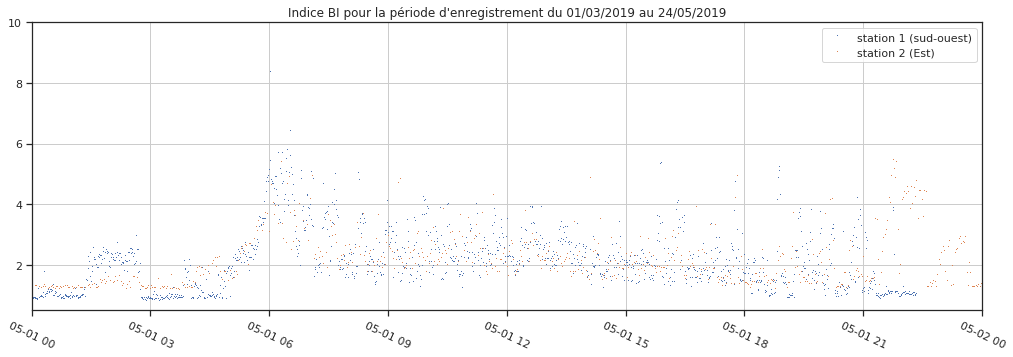

In [6]:
#affichage complet
a = indexes.loc[(indexes['dataset']=='rayol-farm1')]
b = indexes.loc[(indexes['dataset']=='rayol-farm2')]
plt.figure()
plt.plot(a['DATE'],a['BI'], ",", label="station 1 (sud-ouest)")
plt.plot(b['DATE'],b['BI'], ",", label="station 2 (Est)")
plt.title("Indice BI pour la période d'enregistrement du 01/03/2019 au 24/05/2019")
plt.ylim(0.5,10)
plt.xlim(pd.to_datetime("2019-05-01"),pd.to_datetime("2019-05-02"))
plt.grid()
plt.subplots_adjust(top=1, bottom=0, left=0, right=2.2, hspace=0.25,wspace=0.15)
plt.legend(loc='best')
plt.xticks(rotation=-25)
mp.savefig('Figures/BI_all', bbox_inches='tight')

In [7]:
freq
H = []
Ment = []
for i in np.arange(0,48,2):
    
    f = freq.loc[(freq["Heure"]==(i/2)+0*24)|(freq["Heure"]==(i/2)+1*24)|(freq["Heure"]==(i/2)+2*24)|(freq["Heure"]==(i/2)+3*24)|(freq["Heure"]==(i/2)+4*24)|(freq["Heure"]==(i/2)+5*24)|(freq["Heure"]==(i/2)+6*24), ("Freq_0")]
    fp1 = freq.loc[(freq["Heure"]==((i/2)+0*24)+1)|(freq["Heure"]==((i/2)+1*24)+1)|(freq["Heure"]==((i/2)+2*24)+1)|(freq["Heure"]==((i/2)+3*24)+1)|(freq["Heure"]==((i/2)+4*24)+1)|(freq["Heure"]==((i/2)+5*24)+1)|(freq["Heure"]==((i/2)+6*24)+1), ("Freq_0")]
    H += [i/2]
    Ment += [np.mean(f)*8 ]
    H += [(i+1)/2]
    Ment += [(np.mean(f) +np.mean(fp1))*4]

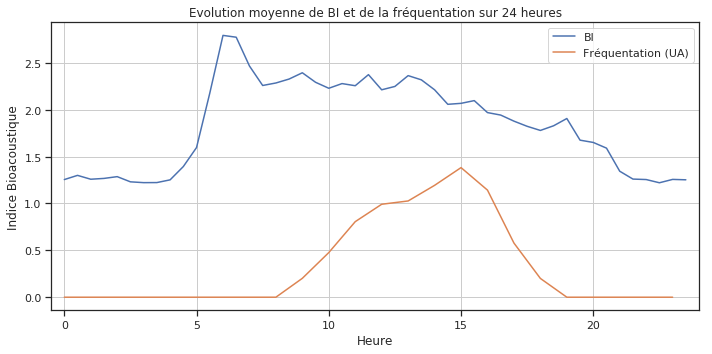

In [8]:
#Affichage de la forme moyenne de 24 H
plt.figure()
plt.plot(np.arange(0,24,0.5),datam.loc[:,('BI', 'MEAN')], label = 'BI')
plt.plot(np.arange(0,24,0.5),Ment, label = 'Fréquentation (UA)')
plt.title('Evolution moyenne de BI et de la fréquentation sur 24 heures')

plt.xlabel('Heure')
plt.ylabel('Indice Bioacoustique')
plt.grid()
plt.xlim(-0.5,24)
plt.subplots_adjust(top=1, bottom=0, left=0, right=1.5, hspace=0.25,wspace=0.15)
plt.legend(loc='best')
mp.savefig('Figures/BI_24h', bbox_inches='tight')

### Evolution de l'éveil du printemps

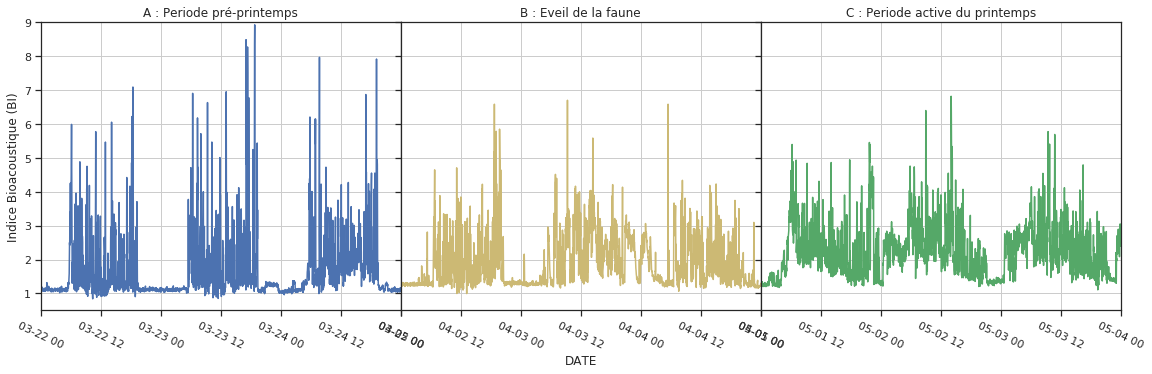

In [9]:
plt.subplot(131)
plt.plot(b['DATE'],b['BI'],'b')
plt.title("A : Periode pré-printemps")
plt.ylabel('Indice Bioacoustique (BI)')
plt.grid()
plt.ylim(0.5,9)
plt.xlim(pd.to_datetime("2019-03-22"),pd.to_datetime("2019-03-25"))
plt.xticks(rotation=-25)


plt.subplot(132)
plt.plot(b['DATE'],b['BI'],"y")
plt.title("B : Eveil de la faune")
plt.xlabel('DATE')
plt.grid()
plt.ylim(0.5,9)
plt.xlim(pd.to_datetime("2019-04-02"),pd.to_datetime("2019-04-05"))
cur_axes = plt.gca()
cur_axes.axes.get_yaxis().set_ticklabels([])
plt.xticks(rotation=-25)


plt.subplot(133)
plt.plot(b['DATE'],b['BI'],"g")
plt.title("C : Periode active du printemps")
plt.grid()
plt.ylim(0.5,9)
plt.xlim(pd.to_datetime("2019-05-01"),pd.to_datetime("2019-05-04"))
cur_axes = plt.gca()
cur_axes.axes.get_yaxis().set_ticklabels([])
plt.xticks(rotation=-25)
plt.subplots_adjust(top=1, bottom=0, left=0, right=2.5, hspace=0.25,wspace=0.0)
mp.savefig('Figures/BI_eveil', bbox_inches='tight')

### Test de corrélation

In [10]:
Ndsi=pd.read_csv("csv/ndsi_ResAll.csv")
AC=pd.read_csv("csv/AC_ResAll.csv")
AD=pd.read_csv("csv/AD_ResAll.csv")
AE=pd.read_csv("csv/AE_ResAll.csv")
BI=pd.read_csv("csv/BI_ResAll.csv")
H=pd.read_csv("csv/H_ResAll.csv")



datat=pd.DataFrame()
#data.columns = pd.MultiIndex(levels = [['INDEXES'], ['ndsi', 'AC','AD','AE','BI','H']])
datat['FILENAME']=H['FILENAME']
datat['ndsi']=Ndsi['LEFT_CHANNEL']
datat['AC']=AC['LEFT_CHANNEL']
datat['AD']=AD['LEFT_CHANNEL']
datat['AE']=AE['LEFT_CHANNEL']
datat['BI']=BI['LEFT_CHANNEL']
datat['H']=H['LEFT_CHANNEL']

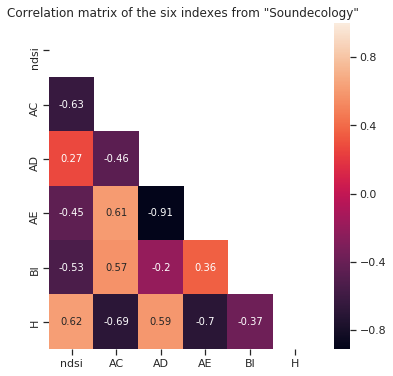

In [11]:
fig, ax = plt.subplots(figsize=(6, 6)) 
mask = np.zeros_like(datat.corr())
mask[np.triu_indices_from(mask)] = 1
sns.heatmap(datat.corr(), mask= mask, ax= ax, annot= True)
plt.title('Correlation matrix of the six indexes from "Soundecology"')

mp.savefig('Figures/Correlation_numb', bbox_inches='tight')

/home/pv/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


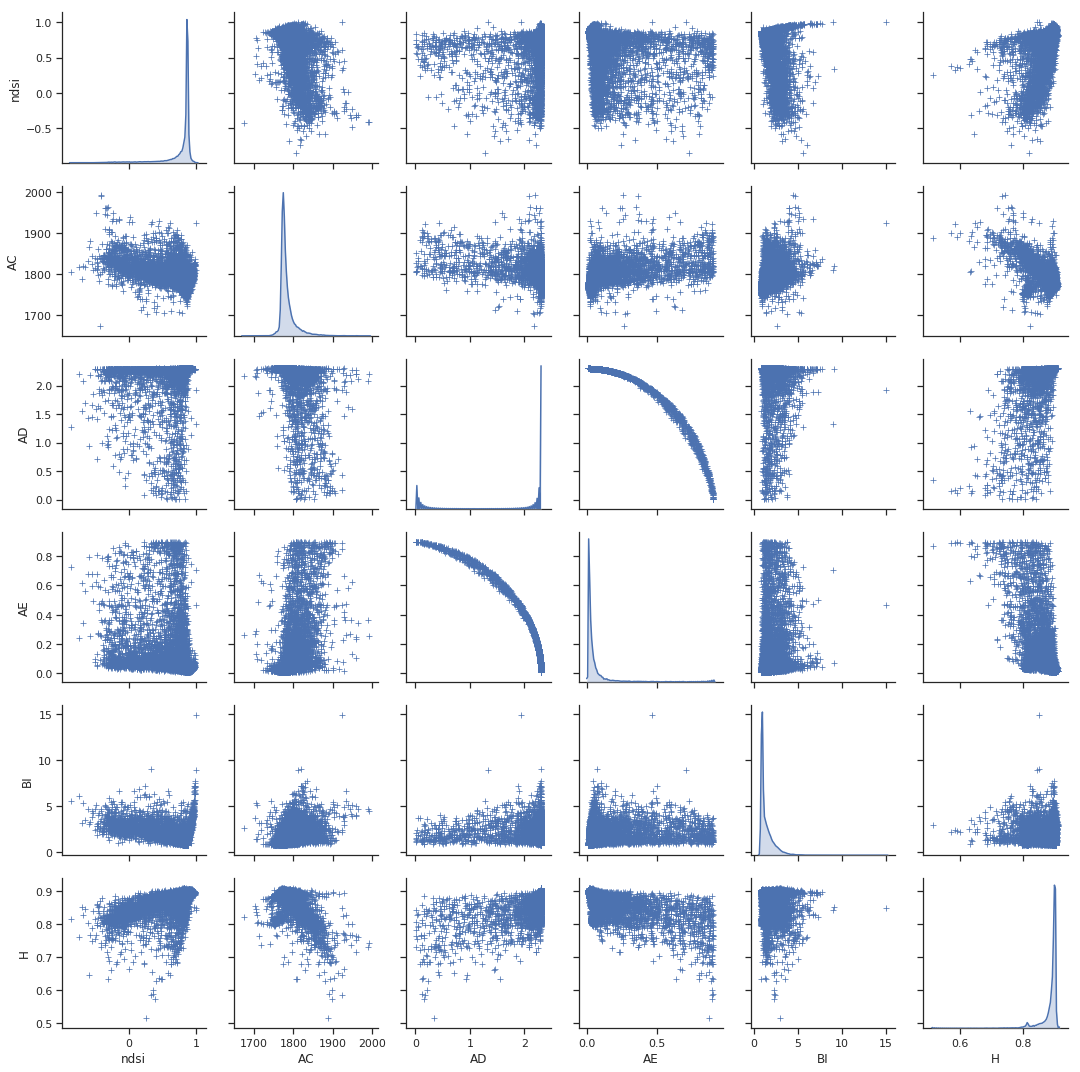

In [12]:
%matplotlib inline
sb.pairplot(datat, markers='+' , diag_kind='kde')
mp.savefig('Figures/Corr_ind', bbox_inches='tight')

In [13]:
ddt= datat.copy()
del ddt["AE"]
ddt.to_csv('data_out/IND_tetrad.csv',header = True, index = False)

# Web-scraper

In [ ]:
#Import
import urllib
import urllib.request
import json
import numpy as np
import time
import os
import pandas as pd
#Def function:

def import_meteo(d1,d2) :
	dt = pd.to_timedelta( 1, unit = 'D' )
	day_list = np.arange( d1, d2, dt )

	DATE = []
	HOUR = []
	TEMP = []
	ENSO_T = []
	RAY = []
	UV_I = []
	HUMID = []
	HUMIDEX = []
	WIND_TEMP = []
	WIND_DIR = []
	WIND_SP = []
	WIND_RF = []
	PRESS = []
	PRECIP = []
	PRECIP_Mx_RATE = []

	for DAY in day_list : 
		day=pd.to_datetime(DAY)
		year = day.year
		month = day.month
		day = day.day
		print('{}-{}-{}'.format(year, month, day))
		url='http://www.meteociel.fr/temps-reel/obs_villes.php?code2=178&jour2={}&mois2={}&annee2={}'.format(day, month, year)

		source = urllib.request.urlopen(url).read().decode("ISO-8859-1")
		rows=[row.split("</td>") for row in source.split("</SCRIPT>")[1].split("</table>")[2].split('<tr> <td align=center>')[1:] if row]
		columns=list(zip(*rows))

		for c in range(len(columns)):
			try:
				columns[c]=np.asarray(list(map(float,columns[c])))
			except Exception:
				pass
		if columns != [] :
			ResultsTab=pd.DataFrame(columns).T

			for i in ResultsTab.index :
				H = ResultsTab.loc[i,(0)].split("<div align=center>")[0].split(' ')[0]
				DATE += [pd.to_datetime('{}-{}-{} {}:00:00'.format(year, month, day, H))]
				HOUR += [H]
				TEMP += [ResultsTab.loc[i,(2)].split("<div align=center>")[1].split(' ')[0].split(';')[-1:][0]]
				
				if '&nbsp;&nbsp;' in ResultsTab.loc[i,(2)].split("<div align=center>")[1] :
					ENSO_T += [ResultsTab.loc[i,(2)].split("<div align=center>")[1].split(' ')[7]]
					RAY += [ResultsTab.loc[i,(2)].split("<div align=center>")[1].split(' ')[11]]
					UV_I += [ResultsTab.loc[i,(2)].split("<div align=center>")[1].split(' ')[15].split("<")[0]]
					
				else :
					ENSO_T += [0]
					RAY += [0]
					UV_I += [0]
					
				HUMID += [ResultsTab.loc[i,(3)].split("<div align=center>")[1].split(' ')[0].split(';')[0].replace('%','')]
				HUMIDEX += [ResultsTab.loc[i,(4)].split("<div align=center>")[1].split(' ')[0].split(';')[0]]
				WIND_TEMP += [ResultsTab.loc[i,(5)].split("<div align=center>")[1].split(' ')[0].split(';')[0]]
				WIND_DIR += [ResultsTab.loc[i,(6)].split("<div align=center>")[1].split("Direction : </i>")[1].split("<")[0]]
				WIND_SP += [ResultsTab.loc[i,(7)].split("<div align=center>")[1].split(' ')[0].split(';')[-1:][0]]
				
				if len(ResultsTab.loc[i,(7)].split("<div align=center>")[1].split('(')) == 2 :
					WIND_RF += [ResultsTab.loc[i,(7)].split("<div align=center>")[1].split('(')[1].split(' ')[0]]
				else :
					WIND_RF += [np.nan]
				
				PRESS += [ResultsTab.loc[i,(8)].split("<div align=center>")[1].split(' ')[0].split(';')[0]]
				
				if ResultsTab.loc[i,(9)].split("<div align=center>")[1].split(' ')[1].split('<')[0] == 'aucune' :
					PRECIP += [0]
				else :
					PRECIP += [ResultsTab.loc[i,(9)].split("<div align=center>")[1].split(' ')[1].split('<')[0]]
				
				PRECIP_Mx_RATE += [ResultsTab.loc[i,(10)].split("<div align=center>")[1].split(' ')[0]]
		else :
			break
	DtFinal = pd.DataFrame([DATE, HOUR, TEMP, ENSO_T, RAY, UV_I, HUMID, HUMIDEX, WIND_TEMP, WIND_DIR, WIND_SP, WIND_RF, PRESS, PRECIP, PRECIP_Mx_RATE], index = ('DATE','HOUR','TEMPERATURE','ENSO_T','RAY', 'UV_I', 'HUMID', 'HUMIDEX', 'WIND_TEMP', 'WIND_DIR', 'WIND_SP', 'WIND_RF', 'PRESSION', 'PRECIPITATION', 'PRECIP_Mx_RATE')).T
	return(DtFinal)

d1 = pd.to_datetime('2019-01-01')

d2 = pd.to_datetime('2019-06-19')


mett = import_meteo(d1,d2)

mett.sort_values(by = 'DATE').to_csv("meteo_final.csv",index = False)

# Test du 24 marsi

### Affichage de la période du 22 au 25 mars

In [14]:
#affichage complet
a = indexes.loc[(indexes['dataset']=='rayol-farm1')]
aa= indexes.loc[(indexes['dataset']=='rayol-farm1')&(indexes['HOUR']>=18)&(indexes['HOUR']<=20)]
plt.figure()
plt.plot(a['DATE'],a['BI'])
plt.plot(aa['DATE'],aa['BI'], ".", label="Coucher du soleil")
plt.title("Indice BI et entrées pour la période d'enregistrement du 22/03/2019 au 25/05/2019")
plt.ylim(0.5,10)
plt.xlim(pd.to_datetime("2019-03-22"),pd.to_datetime("2019-03-26"))
plt.grid()
plt.subplots_adjust(top=1, bottom=0, left=0, right=2.2, hspace=0.25,wspace=0.15)
plt.legend(loc='best')

plt.text("2019-03-22 8:00:00", 5, '117 entrées', fontsize=15,bbox=dict(boxstyle="round", facecolor='white',edgecolor='black'))
plt.text("2019-03-23 8:00:00", 5, '162 entrées', fontsize=15,bbox=dict(boxstyle="round", facecolor='white',edgecolor='black'))
plt.text("2019-03-24 8:00:00", 5, '402 entrées', fontsize=15,bbox=dict(boxstyle="round", facecolor='white',edgecolor='black'))
plt.text("2019-03-25 8:00:00", 5, '79 entrées', fontsize=15,bbox=dict(boxstyle="round", facecolor='white',edgecolor='black'))

mp.savefig('Figures/BI_24_mars', bbox_inches='tight')

### T-test de la période des fins de soirée

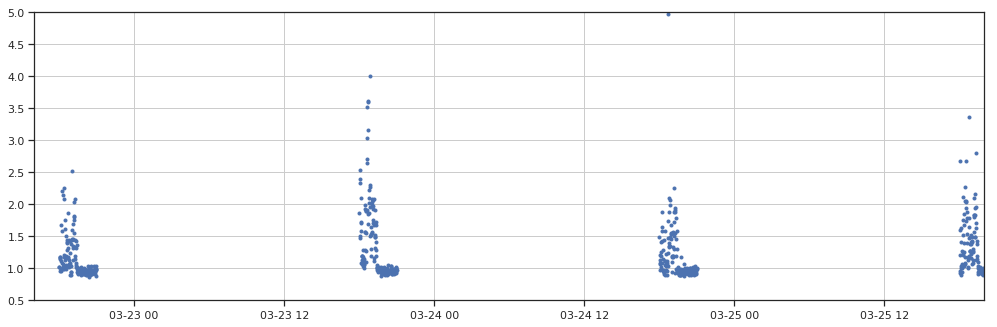

In [15]:
plt.plot(aa['DATE'],aa['BI'], ".", label="station 1 (sud-ouest)")
plt.ylim(0.5,5)
plt.grid()
plt.xlim(pd.to_datetime("2019-03-22 16:00:00"),pd.to_datetime("2019-03-25 20:00:00"))
plt.subplots_adjust(top=1, bottom=0, left=0, right=2.2, hspace=0.25,wspace=0.15)

[<matplotlib.lines.Line2D at 0x7f84abeef710>]

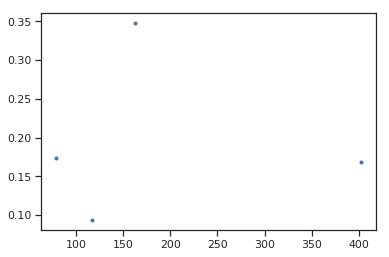

In [16]:
d22 = aa.loc[(aa["DATE"]>"2019-03-22")&(aa["DATE"]<"2019-03-23"),("BI")]
d23 = aa.loc[(aa["DATE"]>"2019-03-23")&(aa["DATE"]<"2019-03-24"),("BI")]
d24 = aa.loc[(aa["DATE"]>"2019-03-24")&(aa["DATE"]<"2019-03-25"),("BI")]
d25 = aa.loc[(aa["DATE"]>"2019-03-25")&(aa["DATE"]<"2019-03-26"),("BI")]

d22v = np.var(d22)
d23v = np.var(d23)
d24v = np.var(d24)
d25v = np.var(d25)
var = [d22v, d23v, d24v, d25v]
ent = [117,162,402,79]
plt.plot(ent,var,'.')

In [18]:
def ttest(d1,d2):
    N = len(d25)
    df = 2*N - 2

    t, p = stats.ttest_ind(d1,d2, 
                             equal_var=False
                            )
    print('')
    print('Day = ',dd,' mars')
    print('Moyenne = ',np.mean(D))
    print('Variance = ',np.var(D))
    print('STD ',np.std(D))
    print('T-Test acec fonction interne scipy :')
    print('N = ' + str(N))
    print('df = ' + str(df))
    print("t = " + str(t))
    print("p = " + str(p))
    return(t,p)
dd=22
for D in [d22,d23,d24,d25]:
    
    t, p =ttest(d24,D)
    dd+=1


Day =  22  mars
Moyenne =  1.1265777816052134
Variance =  0.09299479767823898
STD  0.3049504839777091
T-Test acec fonction interne scipy :
N = 180
df = 358
t = 0.6767472352652734
p = 0.4990401341578473

Day =  23  mars
Moyenne =  1.3350310030687704
Variance =  0.3483295558573958
STD  0.5901945068004241
T-Test acec fonction interne scipy :
N = 180
df = 358
t = -3.3958098144488282
p = 0.0007706131033900485

Day =  24  mars
Moyenne =  1.1524696229098603
Variance =  0.16902006280374227
STD  0.4111204966962147
T-Test acec fonction interne scipy :
N = 180
df = 358
t = 0.0
p = 1.0

Day =  25  mars
Moyenne =  1.2242988826269923
Variance =  0.17385105576075321
STD  0.41695450082803187
T-Test acec fonction interne scipy :
N = 180
df = 358
t = -1.6412035735067338
p = 0.10163352580608961


# E.I.L.M. Heure par Heure

# Formatage des données

In [19]:
#Moyenne de BI h par H
a=pd.to_datetime('2019-03-22 00:00:00')
b=pd.to_datetime('2019-05-28 00:00:00')
dt=pd.to_timedelta('1:00:00')

bimean=[]

da=[]
for i in np.arange(a,b,dt):
    mn=np.mean(data0.loc[(data0['DATE']>=i)&(data0['DATE']<i+dt)]['BI'])
    da+=[i]
    if np.isnan(mn):
        bimean +=[(np.mean(data0.loc[(data0['DATE']>=i-dt)&(data0['DATE']<i)]['BI'])+np.mean(data0.loc[(data0['DATE']>=i+dt)&(data0['DATE']<i+2*dt)]['BI']))/2]
    else:
        bimean += [mn]

dtmoy = pd.DataFrame([da,bimean], index = ('DATE','BI')).T.dropna()

In [11]:
T2 = entrees.loc[80:].copy().reset_index(drop=True)
da = []
month = []#le mois
Wday = []#je jour de la semaine
day = []#le jour
hour = []#l'heure
entr = []#nombre de présence sur site extrapolé de la proportion de fréquence et du nb d'entrées tot
Tp = []#température
Ray = []#raytonnement
Humidity = []#Humidités
Humidex = []#Indice d'humlidité

Ventemp = []#Température du vent
Ventm = []#vents moyens
Pres = []#pression atmo
Prec = []#précipitation

Vismoon = []#% de visibilité ce jour (1 valeur par jour alors il y à répétition > 1 valeur par jour)
# Possible improvement by infering a gradual evolution of the % of visibility

ac_ind = []
ad_ind = []
H_ind = []
bi_ind =[]
ndsi_ind = []

z=0
for i in T2['DATE']:
    e=T2.loc[z,('ENTREES')]
    z+=1
    for j in np.arange(0,24,1):
        t=i.split(' ')
        date = pd.to_datetime('2019-'+str(Mth[t[2]])+'-'+str(t[1])+' '+str(j)+":00:00")
        Tmet = metfin.loc[
            (metfin['DATE'] == date)
        ].reset_index(drop=True)
        Ti = dtmoy.loc[
            (dtmoy['DATE'] == date)
        ].reset_index(drop=True)
        
        if (len(Tmet) != 0) & (len(Ti) != 0) :
        
            month += [Mth[t[2]]]
            Wday += [WD[t[0]]]
            day += [t[1]]
            hour += [j]
            da += [date]
            entr += [round(e*(FreqVisites[t[0]][j]))]

            Tp += [ Tmet.loc[0,('TEMPERATURE')] ]
            Ray += [ Tmet.loc[0,('RAY')] ]
            Humidity += [ Tmet.loc[0,('HUMID')] ]
            Humidex += [ Tmet.loc[0,('HUMIDEX')] ]
            Ventemp += [ Tmet.loc[0,('WIND_TEMP')] ]
            Ventm += [ Tmet.loc[0,('WIND_SP')] ]
            Pres += [ Tmet.loc[0,('PRESSION')] ]
            Prec += [ Tmet.loc[0,('PRECIPITATION')] ]

            Vismoon += [vismoon.loc[vismoon["DATE"] == '2019-'+str(Mth[t[2]])+'-'+str(t[1]),("VIS")].reset_index(drop=True)[0]]
            
            bi_ind +=[Ti.loc[0,('BI')]]



res=pd.DataFrame([hour,entr,Tp,Ray,Humidity,Humidex,Prec,Ventemp,Ventm,Pres, Vismoon, bi_ind],
             index=('HOUR','ENTR','TEMP','RAYONNEMENT','HUMIDITY','HUMIDEX','PRECIPITATION', 'WIND_TEMP','WIND_SP','PRES', 'MOON_VISIBILITY' ,'B_INDEX')).T

res.to_csv('data_out/formated_data.csv',header = True, index = False)

### Test de Corrélation

/home/pv/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


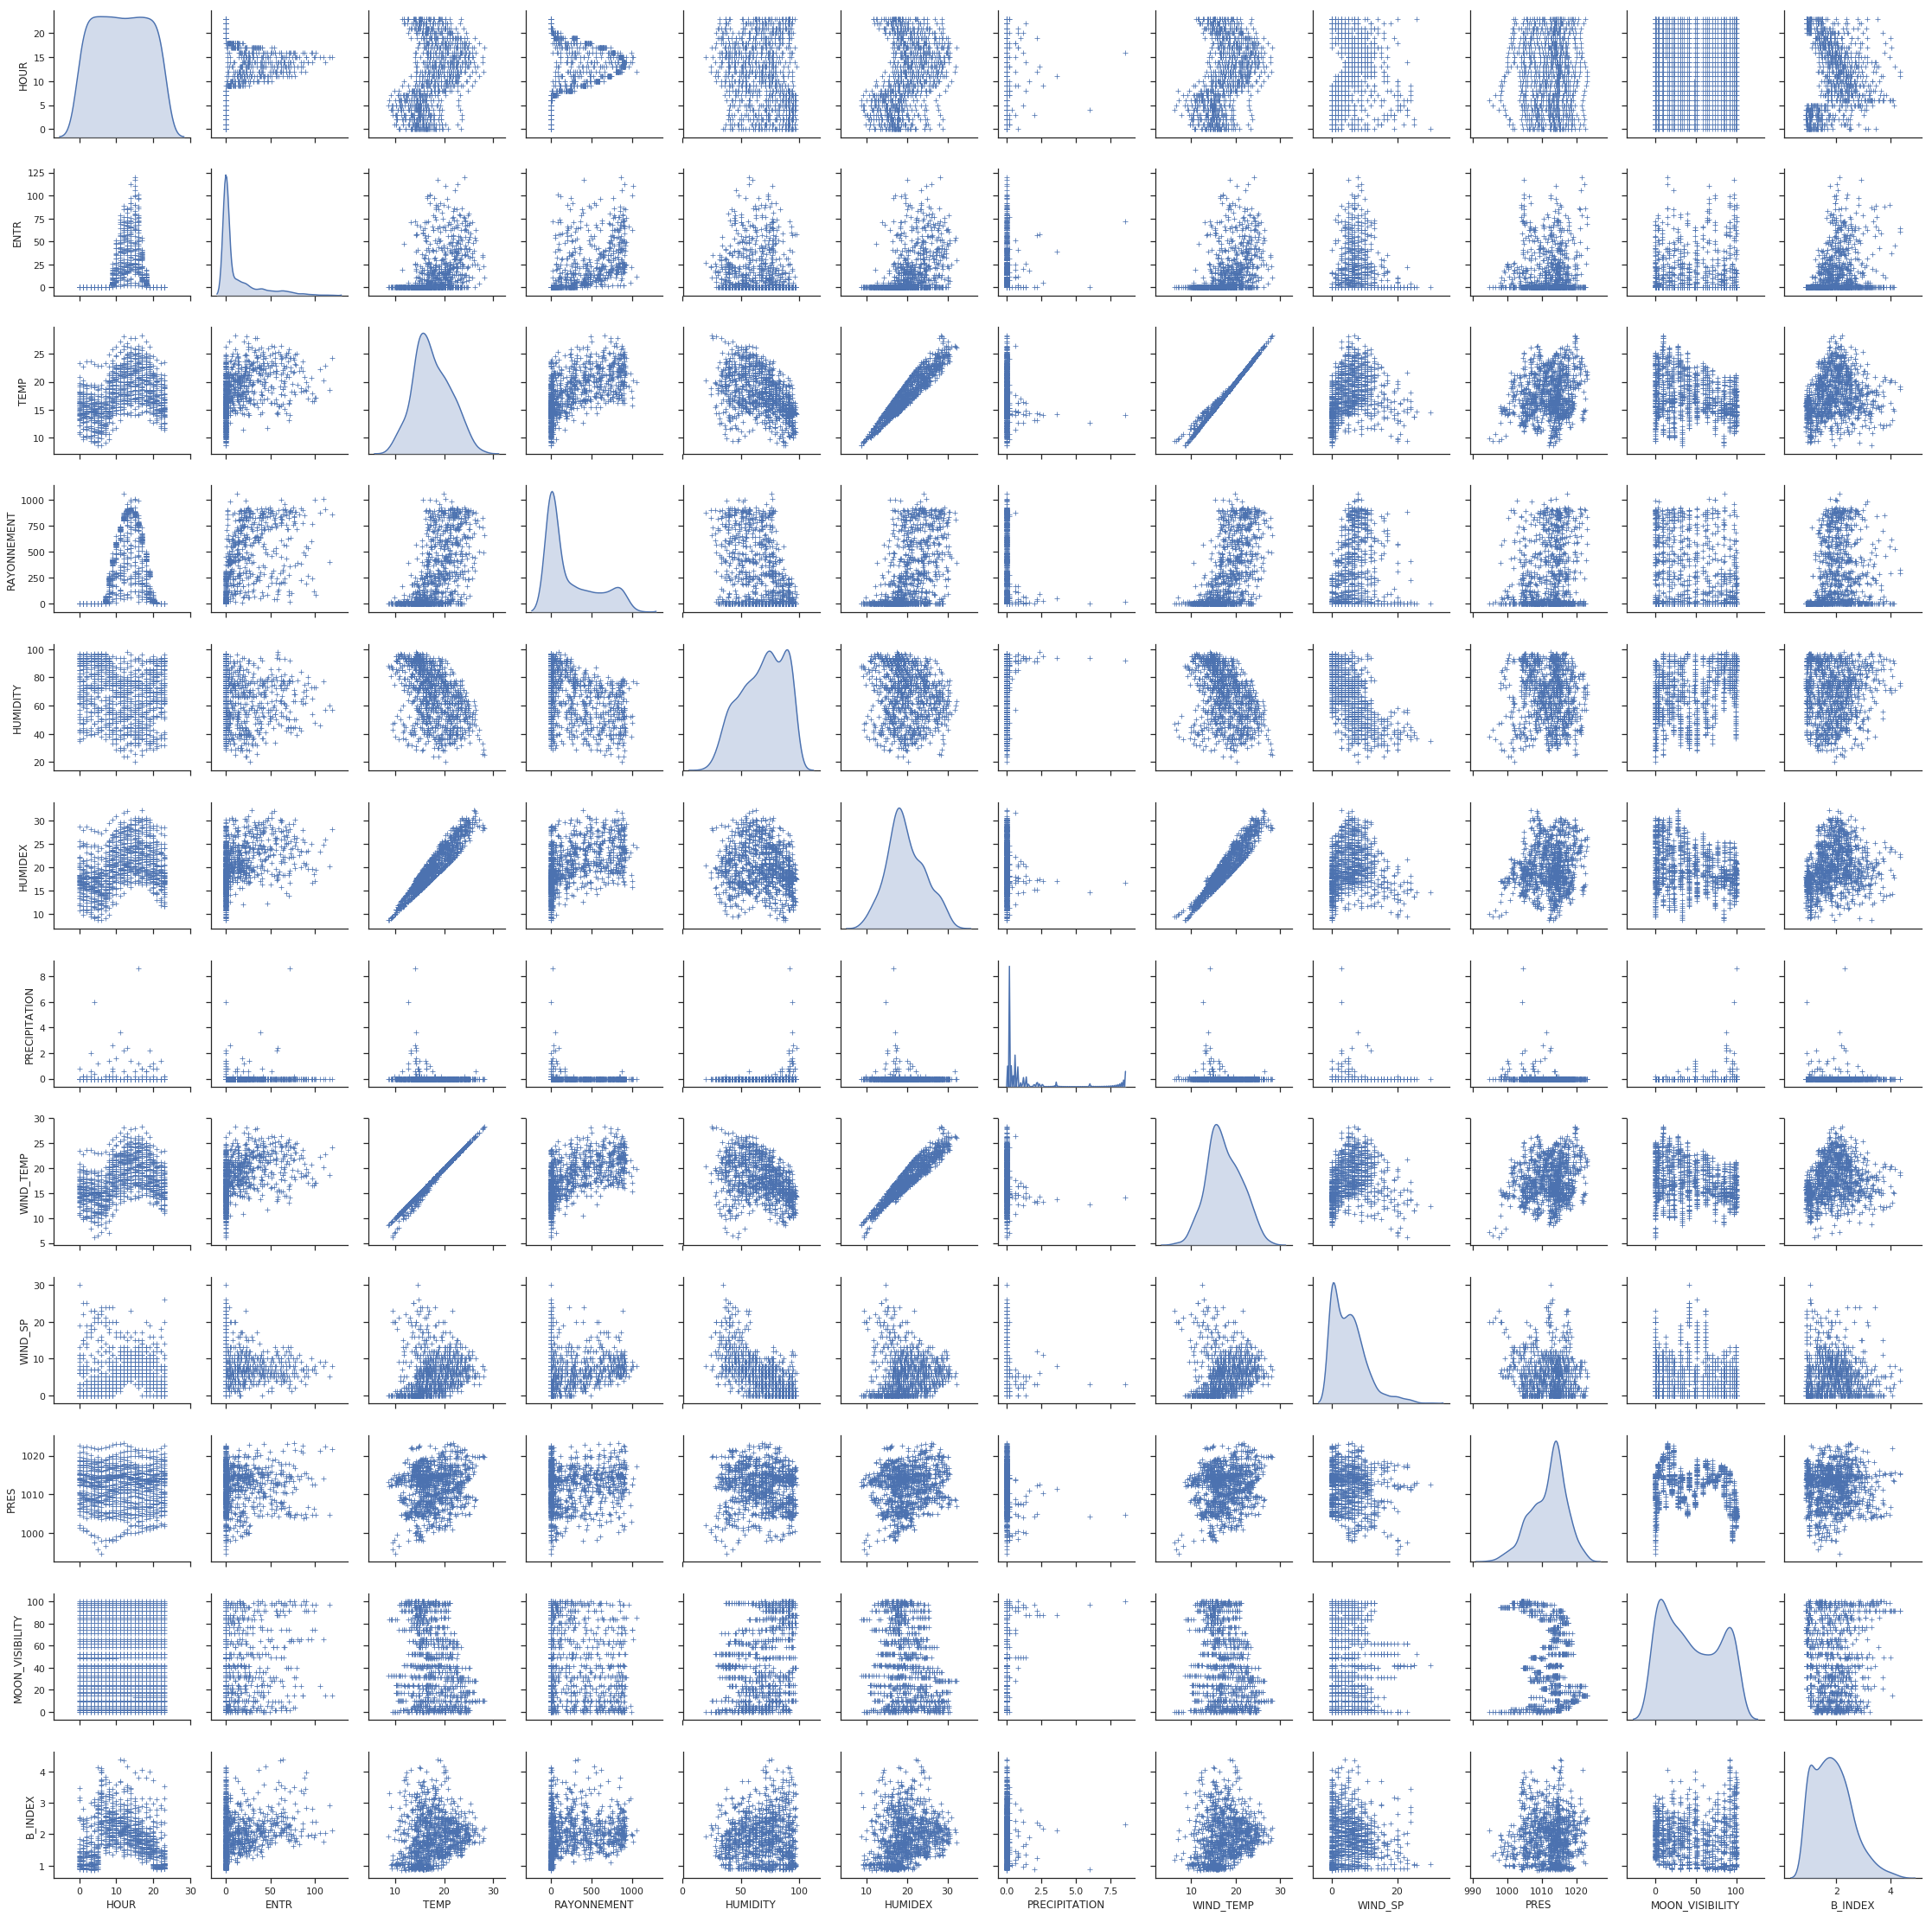

In [12]:
#res = pd.read_csv('data_out/formated_data.csv')
R = res.copy()
bi = R['B_INDEX']
%matplotlib inline
sb.pairplot(R, markers='+' , diag_kind='kde',)
plt.subplots_adjust(top=1, bottom=0, left=0, right=1, hspace=0.25,wspace=0.15)
del R['B_INDEX']
#del R['HOUR']
mp.savefig('Figures/EILM_corr', bbox_inches='tight')

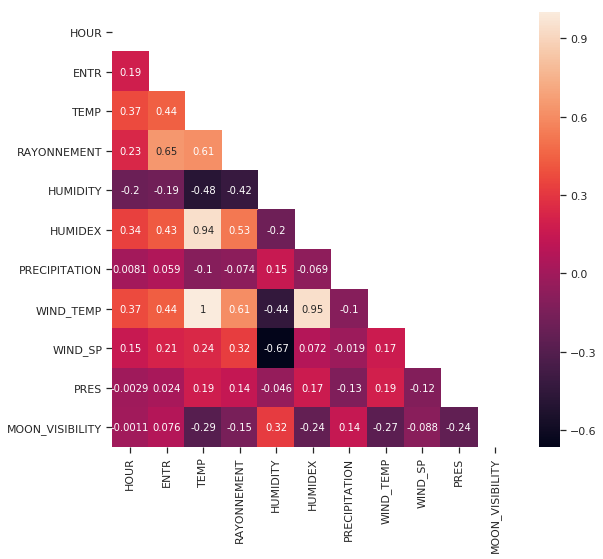

In [13]:
fig, ax = plt.subplots(figsize=(9, 8)) 
mask = np.zeros_like(R.corr())
mask[np.triu_indices_from(mask)] = 1
sns.heatmap(R.corr(), mask= mask, ax= ax, annot= True)
mp.savefig('Figures/EILM_cor_num', bbox_inches='tight')

### Test de Shap

In [21]:
res = pd.read_csv('data_out/formated_data.csv')
R = res.copy()
bi = R['B_INDEX']

del R['HUMIDEX']
del R['WIND_TEMP']
del R['B_INDEX']

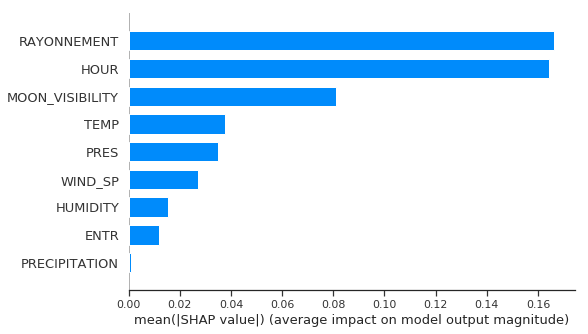

In [23]:
# load JS visualization code to notebook
shap.initjs()
# train XGBoost model
X = R
y = np.asarray(bi)
#X,y = shap.datasets.boston()
model = xgboost.train({"learning_rate": 0.01}, xgboost.DMatrix(X, label=y), 100)
# explain the model's predictions using SHAP values
# (same syntax works for LightGBM, CatBoost, and scikit-learn models)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)
# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
#shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])
shap.summary_plot(shap_values, X, plot_type="bar")

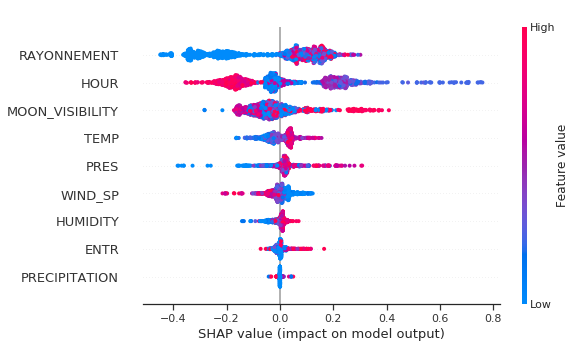

In [24]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X)

In [25]:
res = pd.read_csv('data_out/formated_data.csv')
R = res.copy()

del R['HUMIDEX']
del R['WIND_TEMP']
del R['TEMP']
del R['PRES']
del R['WIND_SP']
del R['HUMIDITY']
del R['PRECIPITATION']
R.to_csv('data_out/ELIM_tetrad.csv',header = True, index = False)